# ECCO v4 salinity budget
$$G^{tot} = G^{adv} + G^{diff} + G^{forc}$$
$$\frac{\partial S}{\partial t} = \frac{1}{s^*} \left[S\,\nabla_{z^*}(s^*\,{\bf v}) + S\,\frac{\partial w}{\partial z^*} - \nabla_{z^*}(s^*\,S\,{\bf v_{res}}) - \frac{\partial S\,w_{res}}{\partial z^*}\right] + D_S + F_S - S\,F$$

In [1]:
import numpy as np 
import xarray as xr
from matplotlib import pyplot as plt
import os

%matplotlib inline

In [2]:
from ecco_read_utilities import *

## Open datasets

In [3]:
# nctiles_monthly
ds_mon = open_ecco_variables('SALT','ETAN','UVELMASS','VVELMASS','WVELMASS','oceFWflx','SFLUX','oceSPtnd',
                             'ADVx_SLT','ADVy_SLT','ADVr_SLT','DFxE_SLT','DFyE_SLT','DFrE_SLT','DFrI_SLT')

In [4]:
# nctiles_tendencies
ds_ten = open_ecco_tendencies('Sad', 'Sdi','Sforc','Stend')

/home/tesdal/.local/lib/python2.7/site-packages/dask/array/core.py:493: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  o = func(*args, **kwargs)


## Add grid cell volume to datasets

In [5]:
ds_mon['vol'] = ds_mon.RAC*ds_mon.DRF*ds_mon.hFacC

In [6]:
ds_ten['vol'] = ds_ten.area*ds_ten.thic*ds_ten.land

## Forcing ($G^{forc}$)
**Note**: The forcing term is comprised of both salt flux (`forcS`) and freshwater flux (`forcV`).

### Volume
- oceFWflx: net surface Fresh-Water flux into the ocean (kg/m^2/s)

In [7]:
# Density kg/m^3
rhoconst = 1029

In [8]:
# Sea surface forcing on volume (1/s)
forcV = ((ds_mon.oceFWflx/rhoconst)/(ds_mon.hFacC*ds_mon.DRF)).transpose('time','face','i2','i3','i4').load()
forcV.values[:,:,1:] = 0*forcV.values[:,:,1:]

/home/tesdal/.local/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in divide
  return func(*args2)
-c:3: RuntimeWarning: invalid value encountered in multiply


### Salt
Note that salt (plume) flux penetrates vertically
- SFLUX: total salt flux (match salt-content variations) (g/m^2/s)
- oceSPtnd: salt tendency due to salt plume flux (g/m^2/s)

In [9]:
# Surface salt flux (1/s)
forcS = (((ds_mon.SFLUX+ds_mon.oceSPtnd)/(rhoconst*1000))/\
         (ds_mon.hFacC*ds_mon.DRF)).transpose('time','face','i2','i3','i4')

### Salinity

In [10]:
# Scale factor
rstarfac = ((ds_mon.Depth + ds_mon.ETAN)/ds_mon.Depth).transpose('time','face','i3','i4')

In [11]:
# Sea surface forcing for salinity (psu/s)
forc = (-ds_mon.SALT*forcV + forcS)/rstarfac

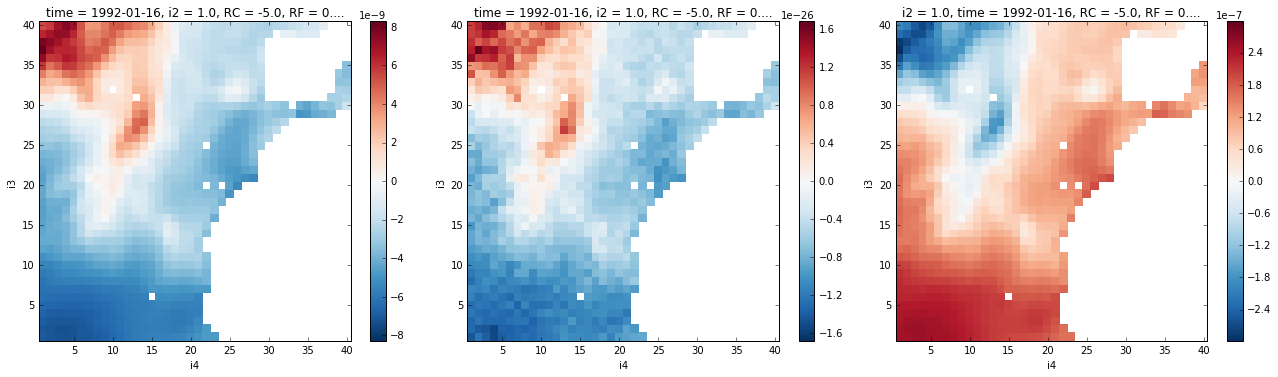

In [12]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.tight_layout()

plt.subplot(1, 3, 1)
forcV[0,2,0,:40,:40].plot()

plt.subplot(1, 3, 2)
forcS[0,2,0,:40,:40].plot()

plt.subplot(1, 3, 3)
forc[0,2,0,:40,:40].plot()

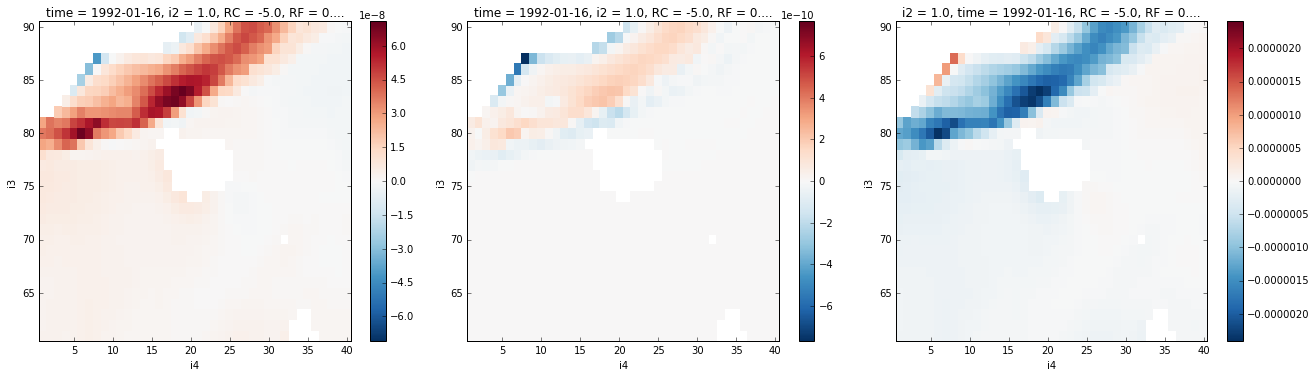

In [13]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.tight_layout()

plt.subplot(1, 3, 1)
forcV[0,2,0,60:,:40].plot()

plt.subplot(1, 3, 2)
forcS[0,2,0,60:,:40].plot()

plt.subplot(1, 3, 3)
forc[0,2,0,60:,:40].plot()

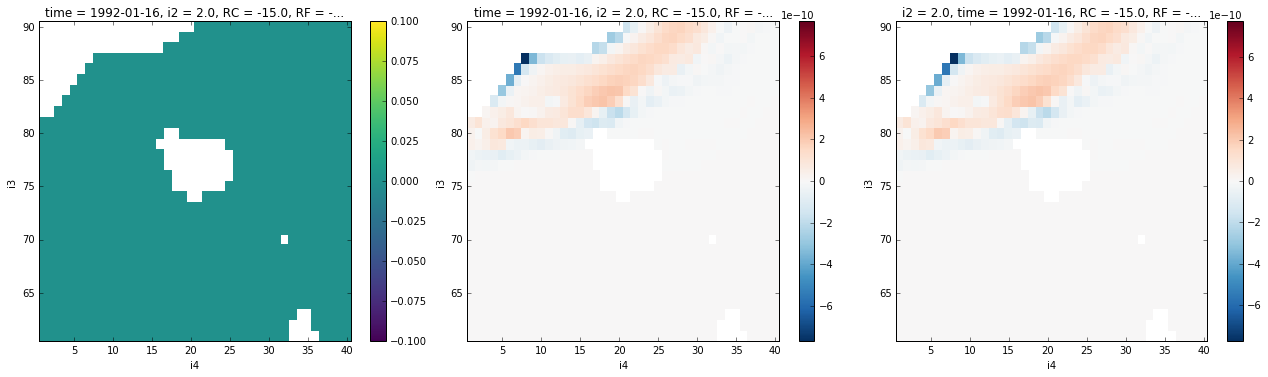

In [14]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.tight_layout()

plt.subplot(1, 3, 1)
forcV[0,2,1,60:,:40].plot()

plt.subplot(1, 3, 2)
forcS[0,2,1,60:,:40].plot()

plt.subplot(1, 3, 3)
forc[0,2,1,60:,:40].plot()

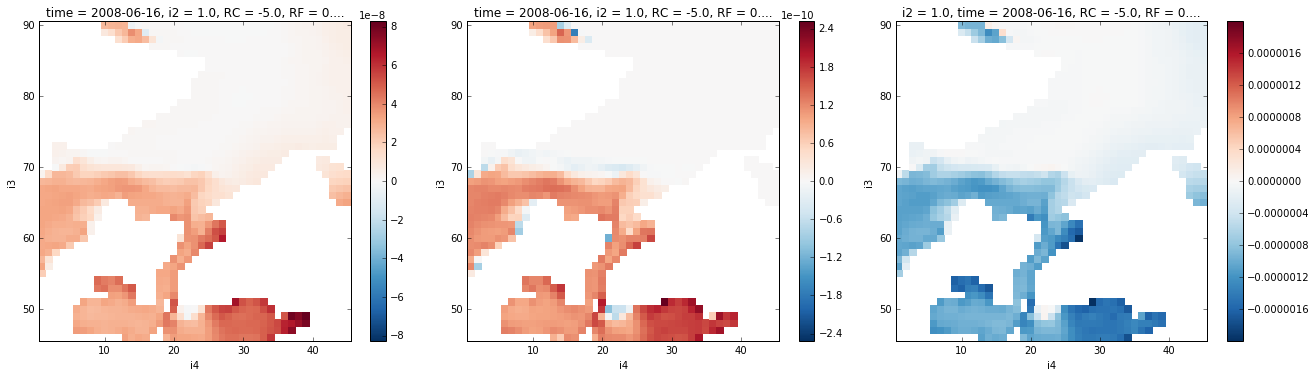

In [15]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.tight_layout()

plt.subplot(1, 3, 1)
forcV[197,10,0,45:,:45].plot()

plt.subplot(1, 3, 2)
forcS[197,10,0,45:,:45].plot()

plt.subplot(1, 3, 3)
forc[197,10,0,45:,:45].plot()

## Advective Flux of Salinity ($G^{adv}$)

**Note**:
- array.shift(i4=-1): shifts array 1 grid point to the left (along x)
- array.shift(i3=-1): shifts array 1 grid point downward (along y)
- array.shift(i2=1): shifts array 1 grid point deeper (along z)

### Volume
- UVELMASS: U Mass-Weighted Comp of Velocity (m/s)
- VVELMASS: V Mass-Weighted Comp of Velocity (m/s)
- WVELMASS: Vertical Mass-Weighted Comp of Velocity (m/s)

In [12]:
# Volume transport (m^3/s)
u_transport = ds_mon.UVELMASS * ds_mon.DYG * ds_mon.hFacW * ds_mon.DRF
v_transport = ds_mon.VVELMASS * ds_mon.DXG * ds_mon.hFacS * ds_mon.DRF

In [13]:
# Divergence of horizontal volume transport (1/s)
div_uv = -(u_transport.shift(i4=-1) - u_transport + v_transport.shift(i3=-1) - v_transport)/ds_mon.vol

In [14]:
# Divergence of vertical volume transport (1/s)
div_w =  -(ds_mon.WVELMASS.shift(i2=1) - ds_mon.WVELMASS)
div_w = div_w.shift(i2=-1)/(ds_mon.hFacC*ds_mon.DRF)

### Salt
- ADVx_SLT: U Comp. Advective Flux of Salinity (psu m^3/s)
- ADVy_SLT: V Comp. Advective Flux of Salinity (psu m^3/s)
- ADVr_SLT: Vertical Advective Flux of Salinity (psu m^3/s)

**Note**: Monthly fields of advection and diffusion are already volume weighted (psu m$^3$s$^{-1}$). To obtain tendency (psu s$^{-1}$) divide by grid cell volume.

In [15]:
# Divergence of horizontal advection (psu/s)
div_adv_h_salt = -(ds_mon.ADVx_SLT.shift(i4=-1) - ds_mon.ADVx_SLT + \
                   ds_mon.ADVy_SLT.shift(i3=-1) - ds_mon.ADVy_SLT)/ds_mon.vol

In [16]:
# Add the vertical salt flux at the air-sea interface to the surface layer of ADVr_SLT
ADVr_SLT = ds_mon.ADVr_SLT.load()
ADVr_SLT[:,:,0] = ADVr_SLT[:,:,0]+(forc*ds_mon.vol)[:,:,0]

In [17]:
# Divergence of vertical advection (psu/s)
#div_adv_v_salt = -(ds_mon.ADVr_SLT.shift(i2=1) - ds_mon.ADVr_SLT)
div_adv_v_salt = -(ADVr_SLT.shift(i2=1) - ADVr_SLT)
div_adv_v_salt = div_adv_v_salt.shift(i2=-1)/ds_mon.vol

In [18]:
div_adv_salt = div_adv_h_salt + div_adv_v_salt

/home/tesdal/.local/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


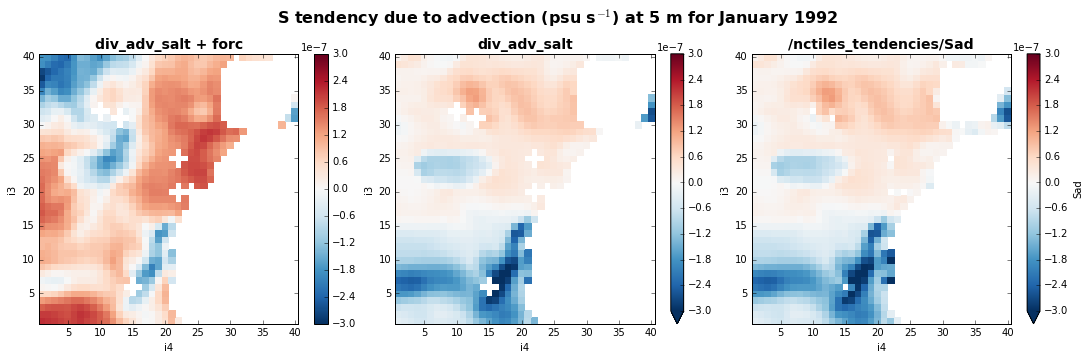

In [23]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.tight_layout()
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.85)

f.suptitle(r'S tendency due to advection (psu s$^{-1}$) at 5 m for January 1992', fontsize=16, fontweight='bold')

plt.subplot(1, 3, 1)
(div_adv_salt+forc)[0,2,0,:40,:40].plot(vmax=3e-7)
plt.title('div_adv_salt + forc', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 2)
div_adv_salt[0,2,0,:40,:40].plot(vmax=3e-7)
plt.title('div_adv_salt', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 3)
ds_ten.Sad.sel(face=5,time=slice('1992-01-01','1992-01-31')).mean('time')[0,:40,:40].plot(vmax=3e-7)
plt.title('/nctiles_tendencies/Sad', fontsize=14, fontweight='bold')

#plt.savefig('figure.png')
plt.show()

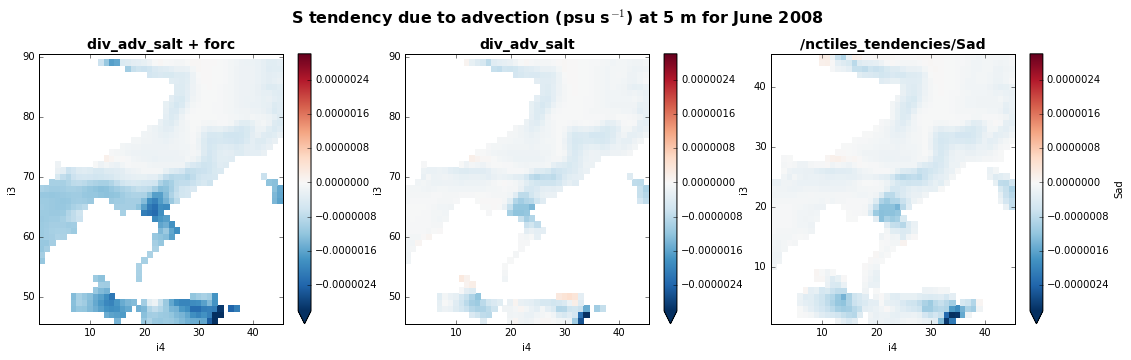

In [24]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.85)

f.suptitle(r'S tendency due to advection (psu s$^{-1}$) at 5 m for June 2008', fontsize=16, fontweight='bold')

plt.subplot(1, 3, 1)
(div_adv_salt+forc)[197,10,0,45:,:45].plot(vmax=3e-6)
plt.title('div_adv_salt + forc', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 2)
div_adv_salt[197,10,0,45:,:45].plot(vmax=3e-6)
plt.title('div_adv_salt', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 3)
ds_ten.Sad.sel(face=42,time=slice('2008-06-01','2008-06-30')).mean('time')[0].plot(vmax=3e-6)
plt.title('/nctiles_tendencies/Sad', fontsize=14, fontweight='bold')

#plt.savefig('figure.png')
plt.show()

### Salinity

In [19]:
div_adv_h = (-ds_mon.SALT*div_uv + div_adv_h_salt)/rstarfac

In [20]:
div_adv_v = (-ds_mon.SALT*div_w + div_adv_v_salt)/rstarfac

In [21]:
div_adv = div_adv_h + div_adv_v

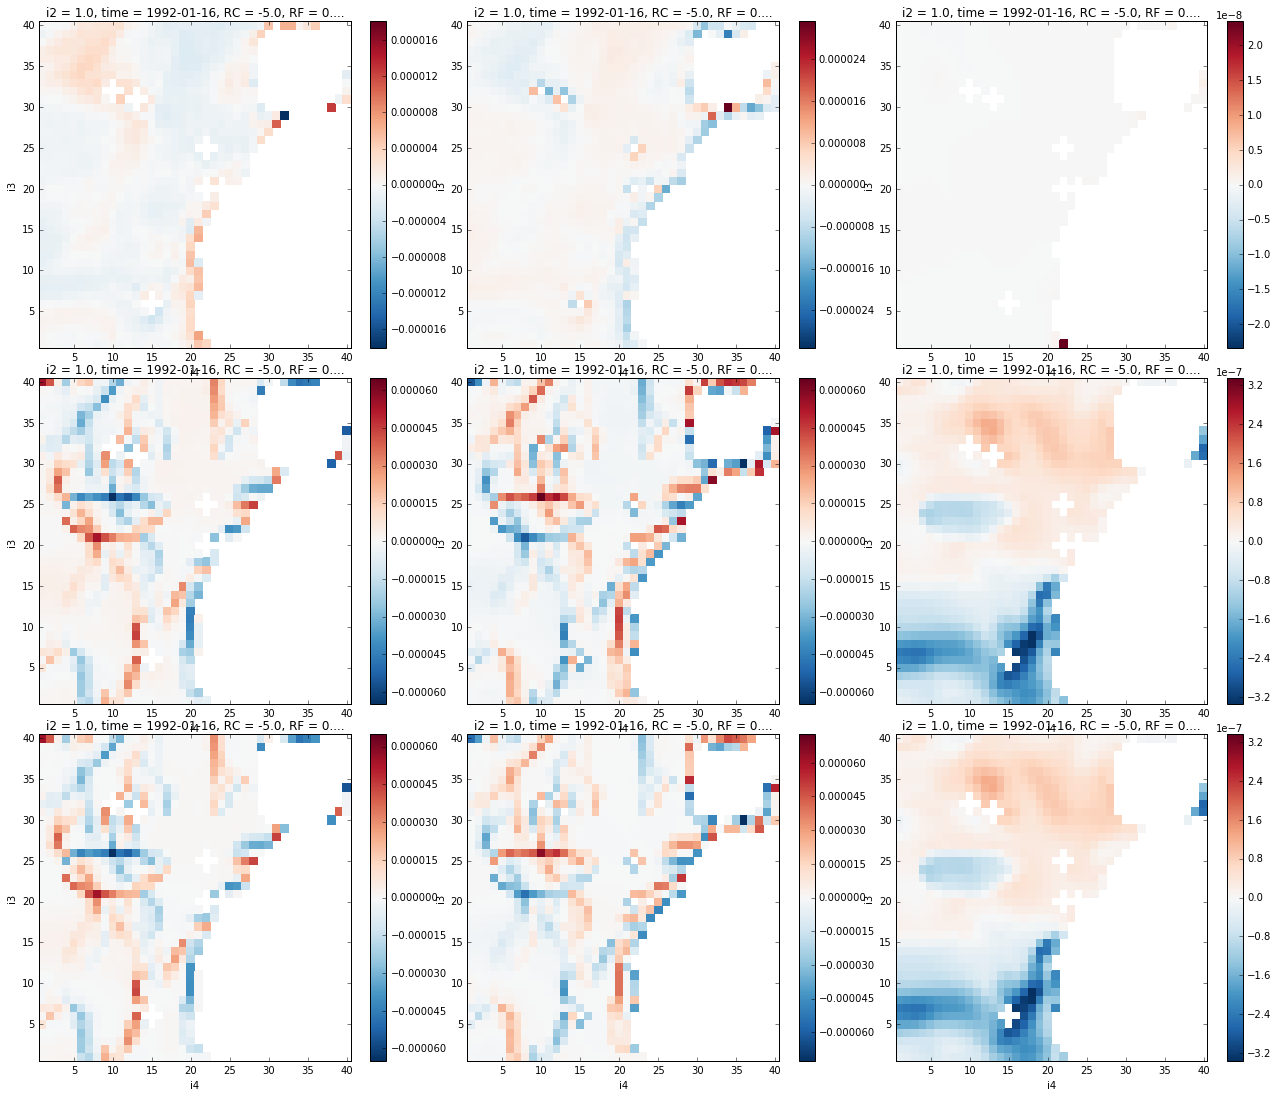

In [28]:
i2 = 0
f, axes = plt.subplots(3, 3,figsize=(18,15))
f.tight_layout()

plt.subplot(3, 3, 1)
(-ds_mon.SALT*div_uv)[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 2)
(-ds_mon.SALT*div_w)[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 3)
(-ds_mon.SALT*(div_uv+div_w))[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 4)
div_adv_h_salt[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 5)
div_adv_v_salt[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 6)
(div_adv_h_salt+div_adv_v_salt)[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 7)
div_adv_h[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 8)
div_adv_v[0,2,i2,:40,:40].plot()

plt.subplot(3, 3, 9)
div_adv[0,2,i2,:40,:40].plot()

#plt.savefig('figure.png')
plt.show()

## Diffusive Flux of Salinity ($G^{diff}$)

**Note**:
- array.shift(i4=-1): shifts array 1 grid point to the left (along x)
- array.shift(i3=-1): shifts array 1 grid point downward (along y)
- array.shift(i2=1): shifts array 1 grid point deeper (along z)

### Salt
- DFxE_SLT: U Comp. Diffusive Flux of Salinity (psu m^3/s)
- DFyE_SLT: V Comp. Diffusive Flux of Salinity (psu m^3/s)
- DFrE_SLT: Vertical Diffusive Flux of Salinity (Explicit part) (psu m^3/s)
- DFrI_SLT: Vertical Diffusive Flux of Salinity (Implicit part) (psu m^3/s)

In [22]:
# Divergence of horizontal diffusion (psu/s)
div_diff_h_salt = (-(ds_mon.DFxE_SLT.shift(i4=-1) - ds_mon.DFxE_SLT + \
                     ds_mon.DFyE_SLT.shift(i3=-1) - ds_mon.DFyE_SLT))/ds_mon.vol

In [23]:
# Divergence of vertical diffusion (psu/s)
div_diff_v_salt = -(ds_mon.DFrE_SLT.shift(i2=1) - ds_mon.DFrE_SLT + \
                     ds_mon.DFrI_SLT.shift(i2=1) - ds_mon.DFrI_SLT)
div_diff_v_salt = div_diff_v_salt.shift(i2=-1)/ds_mon.vol

### Salinity

In [24]:
div_diff_h = div_diff_h_salt/rstarfac

In [25]:
div_diff_v = div_diff_v_salt/rstarfac

In [26]:
div_diff = div_diff_h + div_diff_v

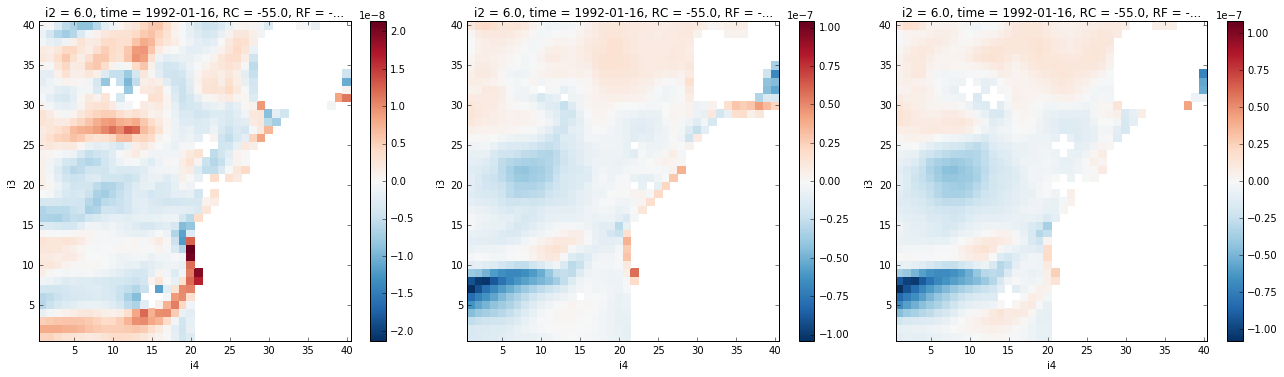

In [34]:
f, axes = plt.subplots(1, 3,figsize=(18,5))
f.tight_layout()

plt.subplot(1, 3, 1)
div_diff_h[0,2,5,:40,:40].plot()

plt.subplot(1, 3, 2)
div_diff_v[0,2,5,:40,:40].plot()

plt.subplot(1, 3, 3)
div_diff[0,2,5,:40,:40].plot()

## Compare to tendencies from snapshots

In [27]:
total = div_adv+div_diff+forc

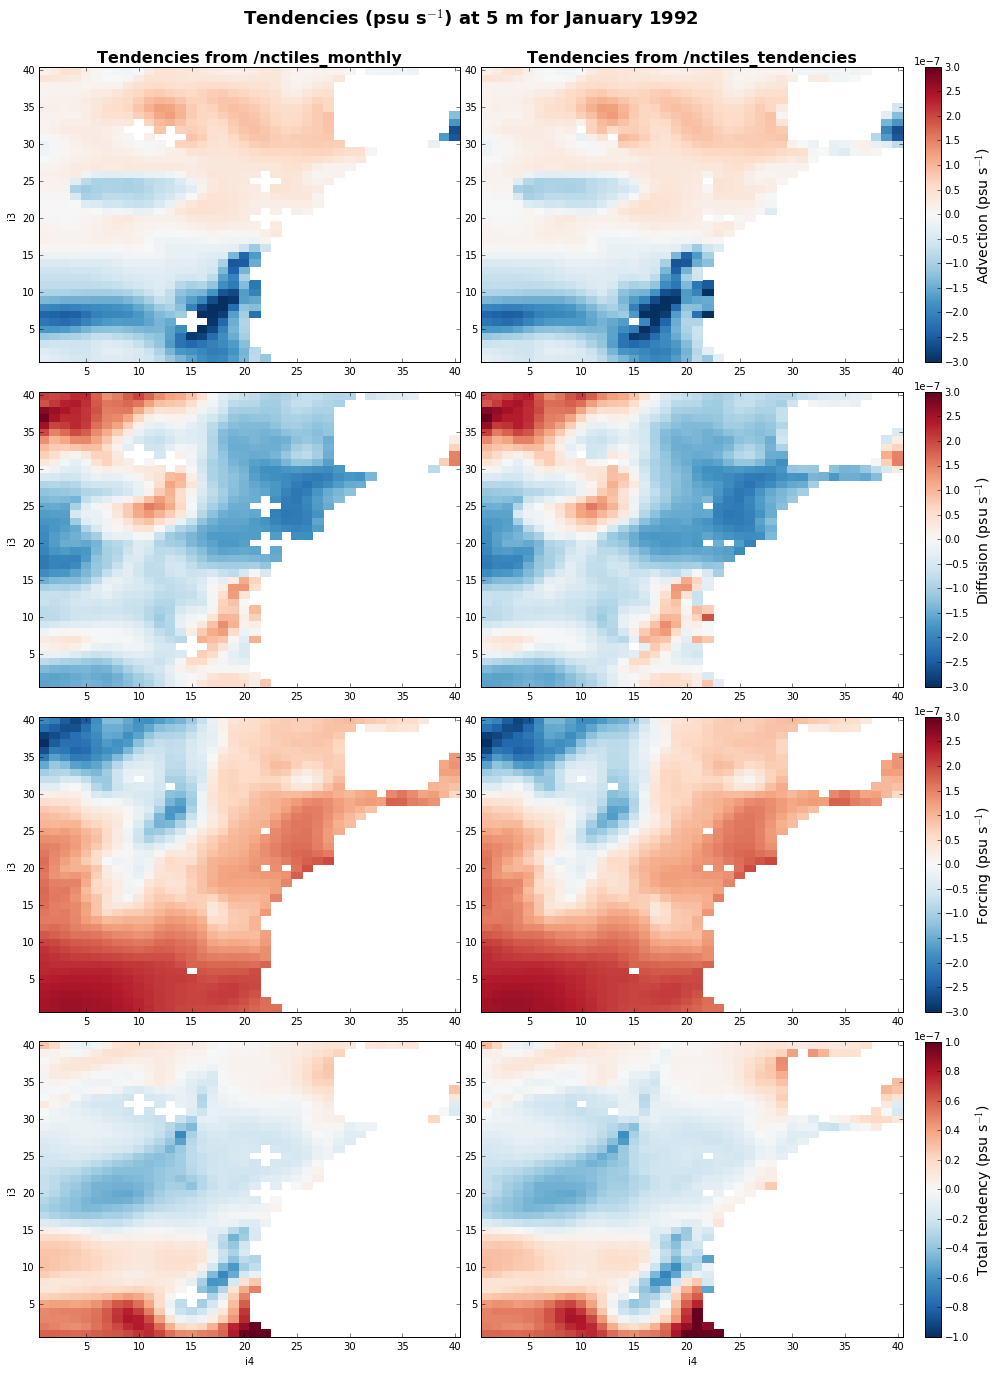

In [36]:
i2 = 0
f, axes = plt.subplots(4, 2, figsize=(15,21))
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.94, hspace=0.1, wspace=0.05)
f.suptitle(r'Tendencies (psu s$^{-1}$) at 5 m for January 1992', fontsize=18, fontweight='bold')

plt.subplot(4, 2, 1)
p=div_adv[0,2,i2,:40,:40].plot(vmax=3e-7,add_colorbar=False)
plt.title('Tendencies from /nctiles_monthly',fontsize=16,fontweight='bold')
plt.xlabel('')

plt.subplot(4, 2, 2)
p=ds_ten.Sad.sel(face=5,time=slice('1992-01-01','1992-01-31')).mean('time')[i2,:40,:40].plot(vmax=3e-7,
                                                                                             add_colorbar=False)
plt.title('Tendencies from /nctiles_tendencies',fontsize=16,fontweight='bold')
plt.xlabel('')
plt.ylabel('')

cbar_ax = f.add_axes([0.92, 0.745, 0.015, 0.195])
cbar = f.colorbar(p,cax=cbar_ax,ticks=1e-7 * np.linspace(-3,3,13))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Advection (psu s$^{-1}$)', fontsize=14)

plt.subplot(4, 2, 3)
p=div_diff[0,2,i2,:40,:40].plot(vmax=3e-7,add_colorbar=False)
plt.xlabel('')
plt.title('')

plt.subplot(4, 2, 4)
p=ds_ten.Sdi.sel(face=5,time=slice('1992-01-01','1992-01-31')).mean('time')[i2,:40,:40].plot(vmax=3e-7,
                                                                                             add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('')

cbar_ax = f.add_axes([0.92, 0.53, 0.015, 0.195])
cbar = f.colorbar(p,cax=cbar_ax,ticks=1e-7 * np.linspace(-3,3,13))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Diffusion (psu s$^{-1}$)', fontsize=14)

plt.subplot(4, 2, 5)
p=forc[0,2,i2,:40,:40].plot(vmax=3e-7,add_colorbar=False)
plt.xlabel('')
plt.title('')

plt.subplot(4, 2, 6)
p=ds_ten.Sforc.sel(face=5,time=slice('1992-01-01','1992-01-31')).mean('time')[i2,:40,:40].plot(vmax=3e-7,
                                                                                               add_colorbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('')

cbar_ax = f.add_axes([0.92, 0.315, 0.015, 0.195]) #+.02
cbar = f.colorbar(p,cax=cbar_ax,ticks=1e-7 * np.linspace(-3,3,13))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Forcing (psu s$^{-1}$)', fontsize=14)

plt.subplot(4, 2, 7)
p=total[0,2,i2,:40,:40].plot(vmax=1e-7,add_colorbar=False)
plt.title('')

plt.subplot(4, 2, 8)
p=ds_ten.Stend.sel(face=5,time=slice('1992-01-01','1992-01-31')).mean('time')[i2,:40,:40].plot(vmax=1e-7,
                                                                                               add_colorbar=False)
plt.ylabel('')
plt.title('')

cbar_ax = f.add_axes([0.92, 0.1, 0.015, 0.195])
cbar = f.colorbar(p,cax=cbar_ax,ticks=1e-7 * np.linspace(-1,1,11))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Total tendency (psu s$^{-1}$)', fontsize=14)

#plt.savefig('figure.png')
plt.show()

In [55]:
ds = div_adv.to_dataset(name='adv')

In [56]:
ds.adv.attrs= {'units': 'psu/s','long_name': 'S tendency due to advection'}

In [58]:
ds['adv_h'] = div_adv_h
ds.adv_h.attrs= {'units': 'psu/s','long_name': 'S tendency due to horizontal advection'}

In [59]:
ds['adv_v'] = div_adv_v
ds.adv_v.attrs= {'units': 'psu/s','long_name': 'S tendency due to vertical advection'}

In [60]:
ds['adv_salt'] = div_adv_salt
ds.adv_salt.attrs= {'units': 'psu/s','long_name': 'S tendency due to advection of salt'}

In [61]:
ds['adv_salt_h'] = div_adv_h_salt
ds.adv_salt_h.attrs= {'units': 'psu/s','long_name': 'S tendency due to horizontal advection of salt'}

In [62]:
ds['adv_salt_v'] = div_adv_v_salt
ds.adv_salt_v.attrs= {'units': 'psu/s','long_name': 'S tendency due to vertical advection of salt'}

In [63]:
ds['dif'] = div_diff
ds.dif.attrs= {'units': 'psu/s','long_name': 'S tendency due to diffusion'}

In [64]:
ds['dif_h'] = div_diff_h
ds.dif_h.attrs= {'units': 'psu/s','long_name': 'S tendency due to horizontal diffusion'}

In [65]:
ds['dif_v'] = div_diff_v
ds.dif_v.attrs= {'units': 'psu/s','long_name': 'S tendency due to vertical diffusion'}

In [66]:
ds['forc'] = forc
ds.forc.attrs= {'units': 'psu/s','long_name': 'S tendency due to forcing'}

In [68]:
# Save dataset to netcdf file
ds.to_netcdf('/home/tesdal/ecco_budg.nc', format='NETCDF4',
             encoding={'adv': {'dtype': 'float32', 'zlib': True},
                       'adv_h': {'dtype': 'float32', 'zlib': True},
                       'adv_v': {'dtype': 'float32', 'zlib': True},
                       'adv_salt': {'dtype': 'float32', 'zlib': True},
                       'adv_salt_h': {'dtype': 'float32', 'zlib': True},
                       'adv_salt_v': {'dtype': 'float32', 'zlib': True},
                       'dif': {'dtype': 'float32', 'zlib': True},
                       'dif_h': {'dtype': 'float32', 'zlib': True},
                       'dif_v': {'dtype': 'float32', 'zlib': True},
                       'forc': {'dtype': 'float32', 'zlib': True}})

### Time series

In [30]:
sad_mon = div_adv[:,10,0,65:85,20:40]*ds_mon.vol.transpose('face','i2','i3','i4')[10,0,65:85,20:40]
sad_ten = ds_ten.Sad[:,41,0,20:40,20:40]*ds_ten.vol.transpose('face','depth','i3','i4')[41,0,20:40,20:40]

In [34]:
sdi_mon = div_diff[:,10,0,65:85,20:40]*ds_mon.vol.transpose('face','i2','i3','i4')[10,0,65:85,20:40]
sdi_ten = ds_ten.Sdi[:,41,0,20:40,20:40]*ds_ten.vol.transpose('face','depth','i3','i4')[41,0,20:40,20:40]

In [35]:
sforc_mon = forc[:,10,0,65:85,20:40]*ds_mon.vol.transpose('face','i2','i3','i4')[10,0,65:85,20:40]
sforc_ten = ds_ten.Sforc[:,41,0,20:40,20:40]*ds_ten.vol.transpose('face','depth','i3','i4')[41,0,20:40,20:40]

In [36]:
stend_mon = total[:,10,0,65:85,20:40]*ds_mon.vol.transpose('face','i2','i3','i4')[10,0,65:85,20:40]
stend_ten = ds_ten.Stend[:,41,0,20:40,20:40]*ds_ten.vol.transpose('face','depth','i3','i4')[41,0,20:40,20:40]

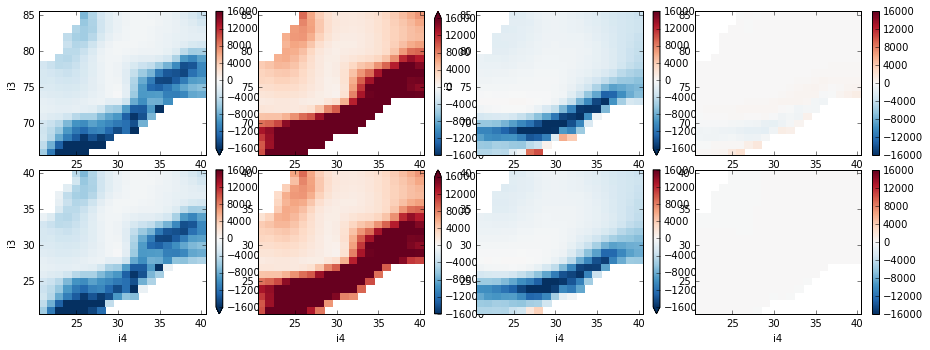

In [52]:
f, axes = plt.subplots(2, 4, figsize=(15,5))
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.94, hspace=0.1, wspace=0.05)

plt.subplot(2, 4, 1)
sad_mon.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.xlabel('')
plt.title('')

plt.subplot(2, 4, 2)
sdi_mon.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.subplot(2, 4, 3)
sforc_mon.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.xlabel('')
plt.title('')

plt.subplot(2, 4, 4)
stend_mon.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.xlabel('')
plt.ylabel('')
plt.title('')

plt.subplot(2, 4, 5)
sad_ten.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.title('')

plt.subplot(2, 4, 6)
sdi_ten.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.ylabel('')
plt.title('')

plt.subplot(2, 4, 7)
sforc_ten.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.title('')
plt.ylabel('')

plt.subplot(2, 4, 8)
stend_ten.mean('time').plot(cmap='RdBu_r',vmin=-1.6e4,vmax=1.6e4)
plt.ylabel('')
plt.title('')

plt.show()

In [37]:
vol_mon = ((sad_mon/sad_mon)*ds_mon.vol.transpose('face','i2','i3','i4')[10,0,65:85,20:40]).sum(dim=['i3', 'i4'])
vol_ten = ((sad_ten/sad_ten)*ds_ten.vol.transpose('face','depth','i3','i4')[41,0,20:40,20:40]).sum(dim=['i3', 'i4'])

In [38]:
Sad_mon = sad_mon.sum(dim=['i3', 'i4'])/vol_mon
Sad_ten = sad_ten.sum(dim=['i3', 'i4'])/vol_ten
Sad_ten_monthly = Sad_ten.resample('1MS', dim='time', how='mean')

In [39]:
Sdi_mon = sdi_mon.sum(dim=['i3', 'i4'])/vol_mon
Sdi_ten = sdi_ten.sum(dim=['i3', 'i4'])/vol_ten
Sdi_ten_monthly = Sdi_ten.resample('1MS', dim='time', how='mean')

In [40]:
Sforc_mon = sforc_mon.sum(dim=['i3', 'i4'])/vol_mon
Sforc_ten = sforc_ten.sum(dim=['i3', 'i4'])/vol_ten
Sforc_ten_monthly = Sforc_ten.resample('1MS', dim='time', how='mean')

In [41]:
Stend_mon = stend_mon.sum(dim=['i3', 'i4'])/vol_mon
Stend_ten = stend_ten.sum(dim=['i3', 'i4'])/vol_ten
Stend_ten_monthly = Stend_ten.resample('1MS', dim='time', how='mean')

In [46]:
import pandas as pd

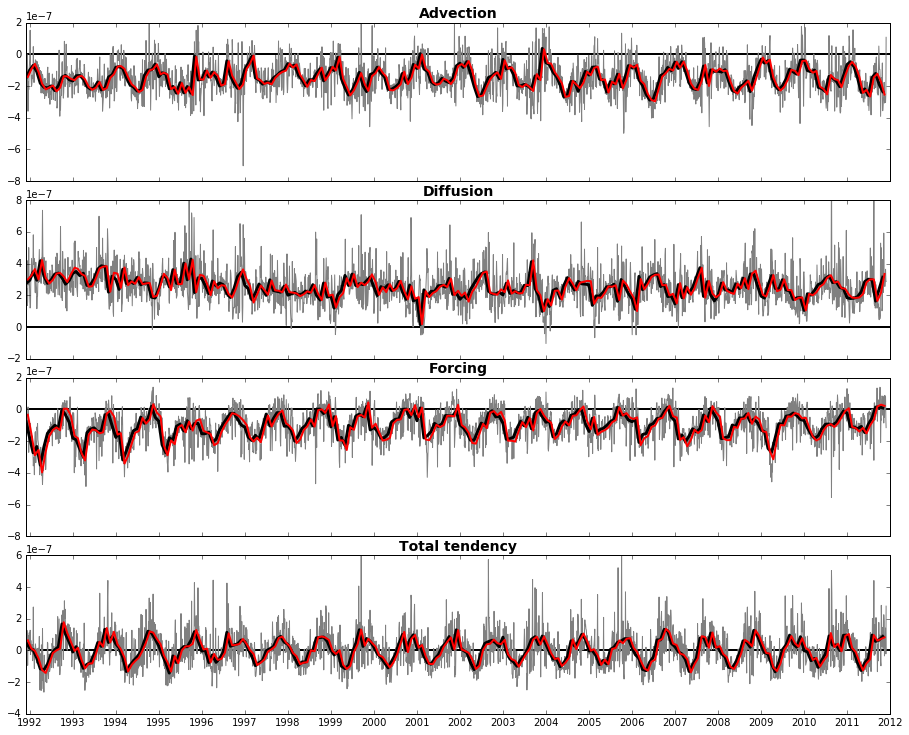

In [53]:
f, axes = plt.subplots(4, 1,figsize=(15,12))
f.tight_layout()

plt.subplot(4, 1, 1)
plt.title(r'Advection',fontsize=14,fontweight='bold')
plt.axhline(y=0, xmin=0, xmax=1, linewidth=2, color = 'k')
plt.plot(Sad_ten.time, Sad_ten, lw=1, color='gray',label='_nolegend_')
plt.plot(Sad_ten_monthly.time, Sad_ten_monthly, lw=3, color='black',label='_nolegend_')
plt.plot(Sad_mon.time, Sad_mon, lw=2, color='red',label='_nolegend_')
plt.ylim([-8e-7,2e-7])
plt.xlim(['1991-12-31','2012-01-01'])
plt.xticks(pd.date_range('1992-01-01','2013-01-01',freq='12M'))
plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(4, 1, 2)
plt.title(r'Diffusion',fontsize=14,fontweight='bold')
plt.axhline(y=0, xmin=0, xmax=1, linewidth=2, color = 'k')
plt.plot(Sdi_ten.time, Sdi_ten, lw=1, color='gray',label='_nolegend_')
plt.plot(Sdi_ten_monthly.time, Sdi_ten_monthly, lw=3, color='black',label='_nolegend_')
plt.plot(Sdi_mon.time, Sdi_mon, lw=2, color='red',label='_nolegend_')
plt.ylim([-2e-7,8e-7])
plt.xlim(['1991-12-31','2012-01-01'])
plt.xticks(pd.date_range('1992-01-01','2013-01-01',freq='12M'))
plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(4, 1, 3)
plt.title(r'Forcing',fontsize=14,fontweight='bold')
plt.axhline(y=0, xmin=0, xmax=1, linewidth=2, color = 'k')
plt.plot(Sforc_ten.time, Sforc_ten, lw=1, color='gray',label='_nolegend_')
plt.plot(Sforc_ten_monthly.time, Sforc_ten_monthly, lw=3, color='black',label='_nolegend_')
plt.plot(Sforc_mon.time, Sforc_mon, lw=2, color='red',label='_nolegend_')
plt.ylim([-8e-7,2e-7])
plt.xlim(['1991-12-31','2012-01-01'])
plt.xticks(pd.date_range('1992-01-01','2013-01-01',freq='12M'))
plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(4, 1, 4)
plt.title(r'Total tendency',fontsize=14,fontweight='bold')
plt.axhline(y=0, xmin=0, xmax=1, linewidth=2, color = 'k')
plt.plot(Stend_ten.time, Stend_ten, lw=1, color='gray',label='_nolegend_')
plt.plot(Stend_ten_monthly.time, Stend_ten_monthly, lw=3, color='black',label='_nolegend_')
plt.plot(Stend_mon.time, Stend_mon, lw=2, color='red',label='_nolegend_')
plt.ylim([-4e-7,6e-7])
plt.xlim(['1991-12-31','2012-01-01'])
plt.xticks(pd.date_range('1992-01-01','2013-01-01',freq='12M'))

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.12)
plt.show()

### Spatial distributions in the North Atlantic

In [37]:
tstart = '2008-06-01'
tend = '2008-10-31'

# depth    (depth) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0
upper = 0
lower = 20

i2_upper = 1
i2_lower = 2

#### Tendencies

In [38]:
print str(ds_ten.Sad.sel(time=slice(tstart,tend),depth=slice(upper,lower)).depth.values[0])
print str(ds_ten.Sad.sel(time=slice(tstart,tend),depth=slice(upper,lower)).depth.values[-1])

5.0
15.0


In [39]:
vol_ten = ds_ten.vol.sel(depth=slice(upper,lower))

In [40]:
Sad_ten = (ds_ten.Sad.sel(time=slice(tstart,tend),
                          depth=slice(upper,lower)).mean('time')*vol_ten).sum('depth',skipna=False)\
            /vol_ten.sum('depth',skipna=False)

Sdi_ten = (ds_ten.Sdi.sel(time=slice(tstart,tend),
                          depth=slice(upper,lower)).mean('time')*vol_ten).sum('depth',skipna=False)\
            /vol_ten.sum('depth',skipna=False)

Sforc_ten = (ds_ten.Sforc.sel(time=slice(tstart,tend),
                              depth=slice(upper,lower)).mean('time')*vol_ten).sum('depth',skipna=False)\
            /vol_ten.sum('depth',skipna=False)

In [41]:
total_ten = (ds_ten.Stend.sel(time=slice(tstart,tend),
                              depth=slice(upper,lower)).mean('time')*vol_ten).sum('depth',skipna=False)\
            /vol_ten.sum('depth',skipna=False)

#### Monthly fields

In [42]:
print str(div_adv.sel(time=slice(tstart,tend),i2=slice(i2_upper,i2_lower)).RC.values[0])
print str(div_adv.sel(time=slice(tstart,tend),i2=slice(i2_upper,i2_lower)).RC.values[-1])

[ -5. -15.]
[ -5. -15.]


In [43]:
vol_mon = ds_mon.vol.sel(i2=slice(i2_upper,i2_lower))

In [44]:
Sad_mon = (div_adv.sel(time=slice(tstart,tend),i2=slice(i2_upper,i2_lower))*vol_mon).sum('i2',skipna=False)\
            /vol_mon.sum('i2',skipna=False)

Sdi_mon = (div_diff.sel(time=slice(tstart,tend),i2=slice(i2_upper,i2_lower))*vol_mon).sum('i2',skipna=False)\
            /vol_mon.sum('i2',skipna=False)

Sforc_mon = (forc.sel(time=slice(tstart,tend),i2=slice(i2_upper,i2_lower))*vol_mon).sum('i2',skipna=False)\
            /vol_mon.sum('i2',skipna=False)

In [45]:
total_mon = Sad_mon+Sdi_mon+Sforc_mon

#### Comparison plot

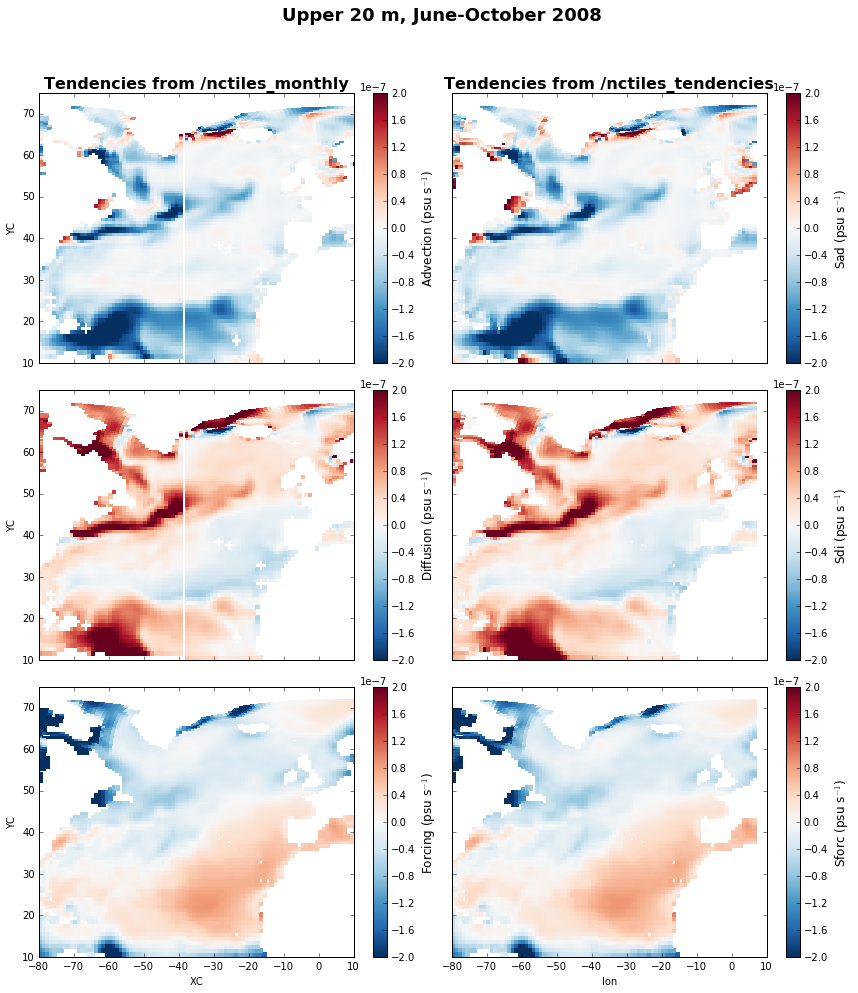

In [46]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(14,15))
f.tight_layout()
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.05)
f.suptitle('Upper 20 m, June-October 2008', fontsize=18, fontweight='bold')

p = Sad_mon.mean('time')[2].plot(x='XC', y='YC', ax=ax1, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sad_mon.mean('time')[10].plot(x='XC', y='YC', ax=ax1, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax1.set_xlim((-80,10))
ax1.set_ylim((10,75))
ax1.set_xlabel('')
ax1.set_title('Tendencies from /nctiles_monthly',fontsize=16,fontweight='bold')
cbar = f.colorbar(p, ax=ax1, ticks=1e-7 * np.linspace(-2,2,11))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Advection (psu s$^{-1}$)', fontsize=12)

p = Sad_ten[41].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sad_ten[5].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sad_ten[43].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sad_ten[4].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax2.set_xlim((-80,10))
ax2.set_ylim((10,75))
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Tendencies from /nctiles_tendencies',fontsize=16,fontweight='bold')
cbar = f.colorbar(p, ax=ax2)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Sad (psu s$^{-1}$)', fontsize=12)

p = Sdi_mon.mean('time')[2].plot(x='XC', y='YC', ax=ax3, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sdi_mon.mean('time')[10].plot(x='XC', y='YC', ax=ax3, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax3.set_xlim((-80,10))
ax3.set_ylim((10,75))
ax3.set_xlabel('')
cbar = f.colorbar(p, ax=ax3)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Diffusion (psu s$^{-1}$)', fontsize=12)

p = Sdi_ten[41].plot(x='lon', y='lat', ax=ax4, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sdi_ten[5].plot(x='lon', y='lat', ax=ax4, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sdi_ten[43].plot(x='lon', y='lat', ax=ax4, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sdi_ten[4].plot(x='lon', y='lat', ax=ax4, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax4.set_xlim((-80,10))
ax4.set_ylim((10,75))
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('')
cbar = f.colorbar(p, ax=ax4)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Sdi (psu s$^{-1}$)', fontsize=12)

p = Sforc_mon.mean('time')[2].plot(x='XC', y='YC', ax=ax5, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sforc_mon.mean('time')[10].plot(x='XC', y='YC', ax=ax5, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax5.set_xlim((-80,10))
ax5.set_ylim((10,75))
cbar = f.colorbar(p, ax=ax5)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Forcing (psu s$^{-1}$)', fontsize=12)

p = Sforc_ten[41].plot(x='lon', y='lat', ax=ax6, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sforc_ten[5].plot(x='lon', y='lat', ax=ax6, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sforc_ten[43].plot(x='lon', y='lat', ax=ax6, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
Sforc_ten[4].plot(x='lon', y='lat', ax=ax6, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax6.set_xlim((-80,10))
ax6.set_ylim((10,75))
ax6.set_ylabel('')
ax6.set_title('')
cbar = f.colorbar(p, ax=ax6)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Sforc (psu s$^{-1}$)', fontsize=12)

#plt.savefig('figure.png')
plt.show()

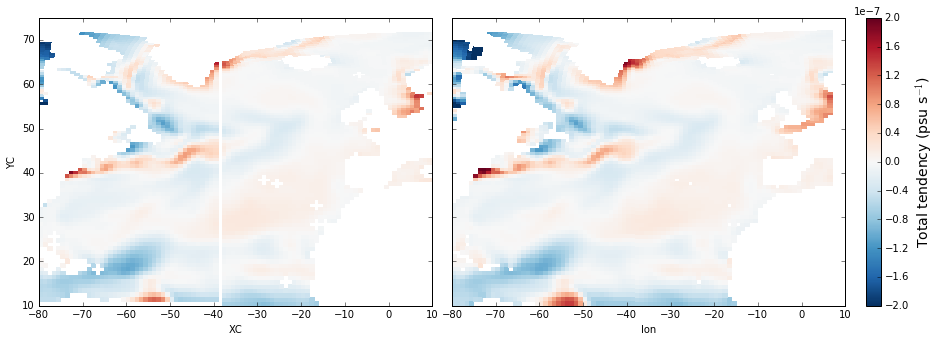

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(14,5))
f.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.05)

p = total_mon.mean('time')[2].plot(x='XC', y='YC', ax=ax1, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
total_mon.mean('time')[10].plot(x='XC', y='YC', ax=ax1, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax1.set_xlim((-80,10))
ax1.set_ylim((10,75))

p = total_ten[41].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
total_ten[5].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
total_ten[43].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
total_ten[4].plot(x='lon', y='lat', ax=ax2, add_colorbar=False,vmin=-2e-7,vmax=2e-7,cmap='RdBu_r')
ax2.set_xlim((-80,10))
ax2.set_ylim((10,75))
ax2.set_ylabel('')
ax2.set_title('')

cbar_ax = f.add_axes([0.92, 0.1, 0.015, 0.8])
cbar = f.colorbar(p,cax=cbar_ax,ticks=1e-7 * np.linspace(-2,2,11))
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.set_label(r'Total tendency (psu s$^{-1}$)', fontsize=14)

plt.show()

### Verical profiles

In [48]:
tstart = '2008-06-01'
tend = '2008-10-31'

face_nr_ten = 42
face_nr_mon = 10

In [49]:
# Lat-lon box in the Labrador Sea
north = 64
south = 55
west = -62
east = -47

In [50]:
Sad_ten = ds_ten.Sad.sel(time=slice(tstart,tend),face=face_nr_ten).mean('time')
Sdi_ten = ds_ten.Sdi.sel(time=slice(tstart,tend),face=face_nr_ten).mean('time')
Sforc_ten = ds_ten.Sforc.sel(time=slice(tstart,tend),face=face_nr_ten).mean('time')
Total_ten = ds_ten.Stend.sel(time=slice(tstart,tend),face=face_nr_ten).mean('time')

vol_ten = ds_ten.vol.sel(face=face_nr_ten)

In [51]:
#Sad_mon = div_adv.sel(time=slice(tstart,tend),face=face_nr_mon).mean('time')
Sad_mon = div_adv_salt.sel(time=slice(tstart,tend),face=face_nr_mon).mean('time')
# Note: The added volume divergence introduces noise (use div_adv_salt instead)

Sdi_mon = div_diff.sel(time=slice(tstart,tend),face=face_nr_mon).mean('time')
Sforc_mon = forc.sel(time=slice(tstart,tend),face=face_nr_mon).mean('time')

vol_mon = ds_mon.vol.sel(face=face_nr_mon)

In [52]:
Total_mon = Sad_mon + Sdi_mon + Sforc_mon

/home/tesdal/.local/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in divide
  return func(*args2)


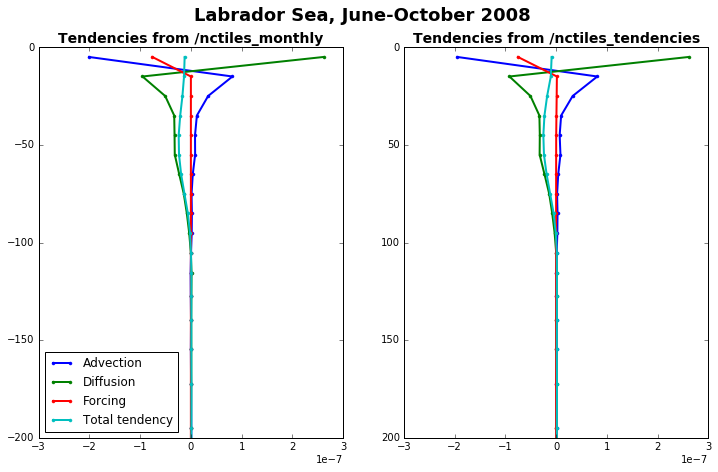

In [53]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
f.suptitle('Labrador Sea, June-October 2008', fontsize=18, fontweight='bold')

plt.subplot(1, 2, 1)
for var in (Sad_mon,Sdi_mon,Sforc_mon,Total_mon):
    var_reg = var.where((var.XC>west)&(var.XC<east)&(var.YC>south)&(var.YC<north))
    vol_reg = vol_mon.where((vol_mon.XC>west)&(vol_mon.XC<east)&(vol_mon.YC>south)&(vol_mon.YC<north))
    var_sum = (var_reg*vol_reg).sum(dim=['i3', 'i4'])
    vol_sum = ((var_reg/var_reg)*vol_reg).sum(dim=['i3', 'i4'])
    var_mean = var_sum/vol_sum
    plt.plot(var_mean, var_mean.RC, lw=2, marker='.')
    
plt.ylim([-200,0])
plt.xlim([-3e-7,3e-7])
plt.legend(['Advection', 'Diffusion', 'Forcing','Total tendency'], loc='lower left')
plt.title('Tendencies from /nctiles_monthly', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
for var in (Sad_ten, Sdi_ten,Sforc_ten,Total_ten):
    var_reg = var.where((var.lon>west)&(var.lon<east)&(var.lat>south)&(var.lat<north))
    vol_reg = vol_ten.where((vol_ten.lon>west)&(vol_ten.lon<east)&(vol_ten.lat>south)&(vol_ten.lat<north))
    var_sum = (var_reg*vol_reg).sum(dim=['i3', 'i4'])
    vol_sum = ((var_reg/var_reg)*vol_reg).sum(dim=['i3', 'i4'])
    var_mean = var_sum/vol_sum
    plt.plot(var_mean.values, var_mean.depth, lw=2, marker='.')

plt.ylim([0,200])
plt.xlim([-3e-7,3e-7])
plt.gca().invert_yaxis()
#plt.legend(['Advection', 'Diffusion', 'Forcing'], loc='lower left')
plt.title('Tendencies from /nctiles_tendencies', fontsize=14, fontweight='bold')

#plt.savefig('figure.png')
plt.show()

/home/tesdal/.local/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in divide
  return func(*args2)


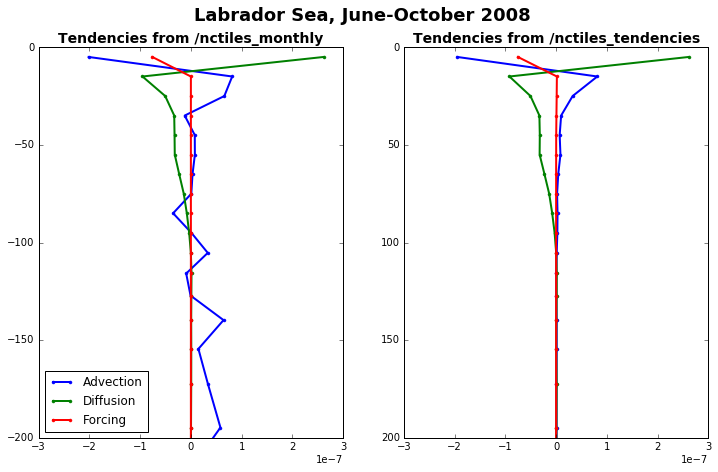